In [1]:
from canonymous.canonicalization import (graph_from_file,
                                         partition_molecule_by_attribute,
                                         partition_molecule_recursively,
                                         assign_canonical_labels,
                                         canonicalize_molecule,
                                         serialize_molecule,
                                         permute_molecule)
from canonymous.visualization import print_molecule, draw_molecules
from pathlib import Path
import networkx as nx


def construct_filepath(name, testset="mol"):
    path = None
    if testset == "mol":
        path = Path(f"tests/molfiles/{name}/{name}.mol")
    elif testset == "cfi":
        path = Path(f"tests/cfi_rigid_benchmark_graphs/{name}.col")
    return path

# Canonicalization

## Introduction
Molecules are represented as graph with atoms as nodes and bonds as edges.
To identify the nodes they are labeled with integers.
When two chemists draw the same molecule, they'll probably label the atoms differently (by drawing the atoms in different orders for instance), as illustrated by the example of ethanol in `Figure 1`.

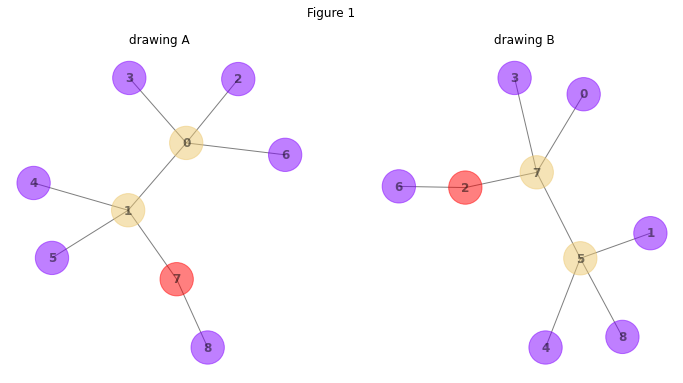

In [2]:
m = graph_from_file(construct_filepath("ethanol"))
m_permuted = permute_molecule(m)
draw_molecules([m, m_permuted], ["drawing A", "drawing B"], highlight="atomic_number", title="Figure 1")

If both molecules were saved in a database, we'd end up with duplicate molecules,
since the chemical structures are equivalent and merely differ in the labels (automorphic).
How do we know that the chemists are submitting the same molecule to the database?
This problem can be solved with canonicalization, that is, by assigning unique (canonical) node labels.
However, the process of finding a canonical labeling can be computationally expensive. 
TODO: Explain brute-force canonicalization / generating all permutations of node labels.
The computational costs of generating all `N!` permutations of the node labels can be reduced substantially by partitioning the atoms into subsets based on invariants.

## Molecule partitioning based on invariants
Invariants are atom-properties that are independent of the labeling. For instance, in `Figure 1`,
the red oxygen atom, irrespective of its label, will always have the atomic number 8, and will always be connected to one carbon and one hydrogen.
The atoms in a partition are equivalent w.r.t. to the invariants.
If each atom resides in a partition of size 1, the molecule has been canonicalized, since each atom can be uniquely identified by its partition.
In practice however, this rarely happens, especially in case of symmetric molecules.
Nevertheless, we aim to partition the molecule such that each partition contains as few atoms as possible.
To achieve this, we need invariants with strong discriminatory power.

We use the following invariants to divide the atoms into partitions.
### Atomic number
The atomic number is a straightforward invariant that doesn't require additional computation.
However, in cases of pure substances such as sulfur, the atomic number has no discriminatory power: all atoms are allocated to the same partition.
In general, based on atomic number alone, we can obtain at most as many partitions as there are different elements in a chemical structure.
### Fundamental cycles
Fundamental cycles are a generalization of [chordless cycles](https://en.wikipedia.org/wiki/Induced_path), such that the chord can contain more than one edge.
For the detection of fundamental cycles, we implemented a variation of the algorithm that has been proposed by [Gashler and Martinez; DOI: 10.1080/09540091.2012.664122](https://axon.cs.byu.edu/papers/cyclecut.pdf) in their Figure 6.
Note that what Gashler and Martinez refer to as "atomic cycle", we call "fundamental cycle".
In doing so, we hope to avoid ambiguity arising from the chemical connotation of the term "atomic".
Importantly, fundamental cycles are not equivalent to chemical rings. While each fundamental cycle is a chemical ring, not every chemical ring is a fundamental cycle. 
In order to obtain an invariant from the fundamental cycles, we associate each atom `a` with all fundamental cycles that contain `a`.

TODO: Show example.

Each fundamental cycle is identified with an integer label, which is not meant to imply that these labels are ordinal, one cycle does not have precedence over the other. The labels are merely meant to distinguish the fundamental cycles from each other. We could use city names but integer labels are more convenient.

### Invariant code
Based on the atomic number and the fundamental cycles, we generate an invariant-code for each atom: `<atomic number>-<comma-separated list of fundamental cycles>`.
Consider for example the invariant code of the atom with label 16 in `Table 1` below.

`6-2,1,0`

The leading 6 indicates that it's a carbon atom. Further, we can infer that it's part of two fundamental cycles: 2 and 1.
Note that all atoms carry a trailing 0 in their invariant codes. The 0s are placeholders in case an atom does not belong to a fundamental cycle.
As is evident from `Table 1`, the invariant-code partitions the molecule into four subsets (partition 0 through 3).

Table 1. Naphthalene partitioned by invariant-code.
╒═════════╤══════════════════╤═════════════╤══════════════════════════════════════════════════╕
│   label │ invariant-code   │   partition │ neighbors (label, invariant-code, partition)     │
╞═════════╪══════════════════╪═════════════╪══════════════════════════════════════════════════╡
│       0 │ 1-0              │           0 │ (11, 6-1,0, 1)                                   │
├─────────┼──────────────────┼─────────────┼──────────────────────────────────────────────────┤
│       1 │ 1-0              │           0 │ (8, 6-1,0, 1)                                    │
├─────────┼──────────────────┼─────────────┼──────────────────────────────────────────────────┤
│       2 │ 1-0              │           0 │ (9, 6-1,0, 1)                                    │
├─────────┼──────────────────┼─────────────┼──────────────────────────────────────────────────┤
│       3 │ 1-0              │           0 │ (10, 6-1,0, 1)                         

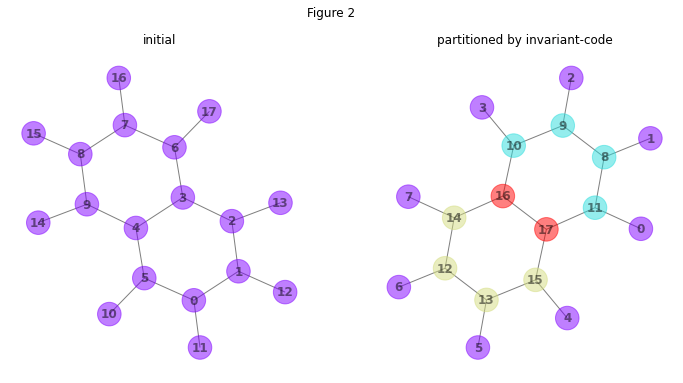

In [3]:
molecule = "naphthalene"
m = graph_from_file(construct_filepath(molecule))
m_partitioned_by_invariants = partition_molecule_by_attribute(m, "invariant_code", include_neighbors=False)
print_molecule(m_partitioned_by_invariants, f"Table 1. {molecule.capitalize()} partitioned by invariant-code.")
draw_molecules([m, m_partitioned_by_invariants], ["initial", "partitioned by invariant-code"], highlight="partition", title="Figure 2")

### Extended invariant code
So far, we only considered invariants that pertain to a single atom.
However, we can increase the discriminatory power of the local invariants by extending them with the properties of the direct neighbors of an atom, that is, all neighboring atoms that are connected to the atom by a single edge.
For example, atoms 9 and 10 from partition 1 are each connected to three direct neighbors: two carbons, and one hydrogen, as indicated by the leading 6s and 1s of the neighbors' invariant-codes.

| label | invariant-code | partition | neighbors (label, invariant-code, partition) |
|---|---|---|---|
| 9 | 6-1,0 | 1 | (8, 6-1,0, 1), (10, 6-1,0, 1), (2, 1-0, 0) |
| 10 | 6-1,0 | 1 | (16, 6-2,1,0, 3), (9, 6-1,0, 1), (3, 1-0, 0) |

However, the neighboring carbon atoms with labels 8 and 16 split partition 1, since atom 16 is connected to fundamental cycles 2 and 1, whereas atom 8 is only connected to fundamental cycle 1. That is, we can discriminate the atoms 9 and 10 based on their neighbors' invariant-codes.
If we apply the partitioning by neighboring invariants (i.e., the extended invariant code) to the entire molecule we end up with a total of seven partitions, three more compared to the partitioning by local invariants, as can be seen below in `Table 2` and `Figure 3`.

Table 2. Naphthalene partitioned by extended invariant-code.
╒═════════╤══════════════════╤═════════════╤══════════════════════════════════════════════════╕
│   label │ invariant-code   │   partition │ neighbors (label, invariant-code, partition)     │
╞═════════╪══════════════════╪═════════════╪══════════════════════════════════════════════════╡
│       0 │ 1-0              │           0 │ (11, 6-1,0, 3)                                   │
├─────────┼──────────────────┼─────────────┼──────────────────────────────────────────────────┤
│       1 │ 1-0              │           0 │ (8, 6-1,0, 2)                                    │
├─────────┼──────────────────┼─────────────┼──────────────────────────────────────────────────┤
│       2 │ 1-0              │           0 │ (9, 6-1,0, 2)                                    │
├─────────┼──────────────────┼─────────────┼──────────────────────────────────────────────────┤
│       3 │ 1-0              │           0 │ (10, 6-1,0, 3)                

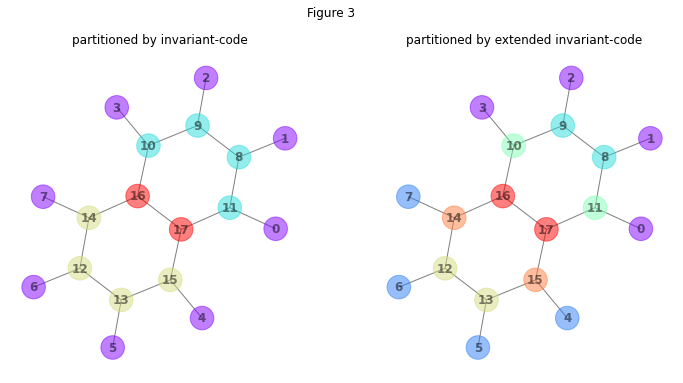

In [4]:
m_partitioned_by_extended_invariants = partition_molecule_by_attribute(m, "invariant_code", include_neighbors=True)
print_molecule(m_partitioned_by_extended_invariants, f"Table 2. {molecule.capitalize()} partitioned by extended invariant-code.")
draw_molecules([m_partitioned_by_invariants, m_partitioned_by_extended_invariants],
               ["partitioned by invariant-code", "partitioned by extended invariant-code"],
               highlight="partition", title="Figure 3")

When we have a look at atoms 0 through 3 from partition 0 in `Table 2`, we notice that atoms 0 and 3 are connected to neighbors from partition 3, whereas atoms 1 and 2 are connected to neighbors from partition 2.

|   label | invariant-code   |   partition | neighbors (label, invariant-code, partition)     |
|---|---|---|---|
|       0 | 1-0              |           0 | (11, 6-1,0, 3)                                   |
|       1 | 1-0              |           0 | (8, 6-1,0, 2)                                    |
|       2 | 1-0              |           0 | (9, 6-1,0, 2)                                    |
|       3 | 1-0              |           0 | (10, 6-1,0, 3)                                   |

This means that we can further discriminate the atoms in partition 0 based on the partitions of their neighbors.
In other words, we can refine the partitions recursively ("partitioning by partition").
`Table 3` and `Figure 4` show that the recursive partitioning yields two more partitions, increasing the number of partitions to nine.

Table 3. Naphthalene partitioned recursively.
╒═════════╤══════════════════╤═════════════╤══════════════════════════════════════════════════╕
│   label │ invariant-code   │   partition │ neighbors (label, invariant-code, partition)     │
╞═════════╪══════════════════╪═════════════╪══════════════════════════════════════════════════╡
│       0 │ 1-0              │           0 │ (8, 6-1,0, 4)                                    │
├─────────┼──────────────────┼─────────────┼──────────────────────────────────────────────────┤
│       1 │ 1-0              │           0 │ (9, 6-1,0, 4)                                    │
├─────────┼──────────────────┼─────────────┼──────────────────────────────────────────────────┤
│       2 │ 1-0              │           1 │ (11, 6-1,0, 5)                                   │
├─────────┼──────────────────┼─────────────┼──────────────────────────────────────────────────┤
│       3 │ 1-0              │           1 │ (10, 6-1,0, 5)                               

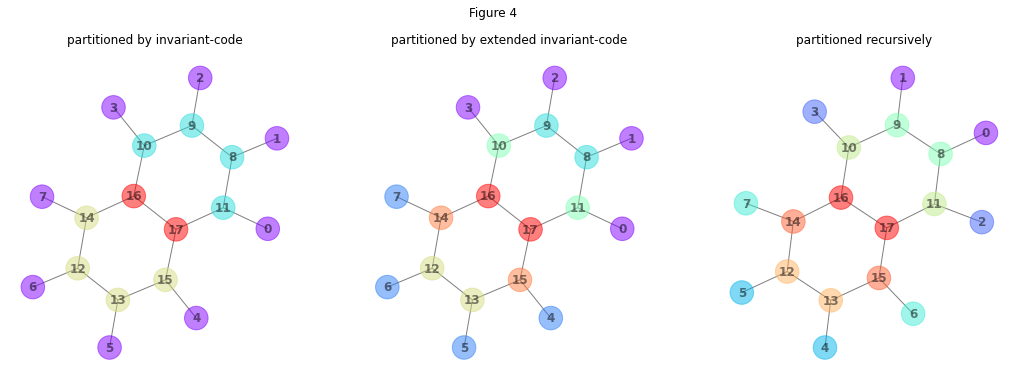

In [5]:
m_partitioned = partition_molecule_recursively(m_partitioned_by_extended_invariants)
print_molecule(m_partitioned, f"Table 3. {molecule.capitalize()} partitioned recursively.")
draw_molecules([m_partitioned_by_invariants, m_partitioned_by_extended_invariants, m_partitioned],
               ["partitioned by invariant-code", "partitioned by extended invariant-code", "partitioned recursively"],
               highlight="partition", title="Figure 4")

After the recursive refinement of the partitions, each partition contains two atoms. This brings us closer to the ultimate goal of the canonicalization, that is, we are closer to shattering the molecule such that each atom resides in a unique partition. However, as we hope to demonstrate in the following, for many molecules it's not strictly necessary to shatter the molecule in order to canonicalize it. Instead, we show that a molecule can be canonicalized once we're able to traverse the molecular graph in a deterministic manner.

## Molecule traversal

Traversing molecule deterministically by branching in a principled way based on partitions.
I.e., establish branching-priorities for situations when traversal can branch to multiple neighbors from atom A:
1. neighbor with larger partition than A
2. neighbor with smaller partition than A
3. neighbor in same partition as A

During traversal, swap indices such that the current molecule A from partition P gets assigned the smallest-available index that remains in partition P. Elaborate.

Current atom index: 0.	Re-labeling to 0.
Current atom index: 8.	Re-labeling to 8.
Current atom index: 11.	Re-labeling to 10.
Current atom index: 9.	Re-labeling to 9.
Current atom index: 17.	Re-labeling to 16.
Current atom index: 2.	Re-labeling to 2.
Current atom index: 10.	Re-labeling to 11.
Current atom index: 1.	Re-labeling to 1.
Current atom index: 15.	Re-labeling to 14.
Current atom index: 16.	Re-labeling to 17.
Current atom index: 3.	Re-labeling to 3.
Current atom index: 6.	Re-labeling to 6.
Current atom index: 13.	Re-labeling to 12.
Current atom index: 14.	Re-labeling to 15.
Current atom index: 4.	Re-labeling to 4.
Current atom index: 12.	Re-labeling to 13.
Current atom index: 7.	Re-labeling to 7.
Current atom index: 5.	Re-labeling to 5.


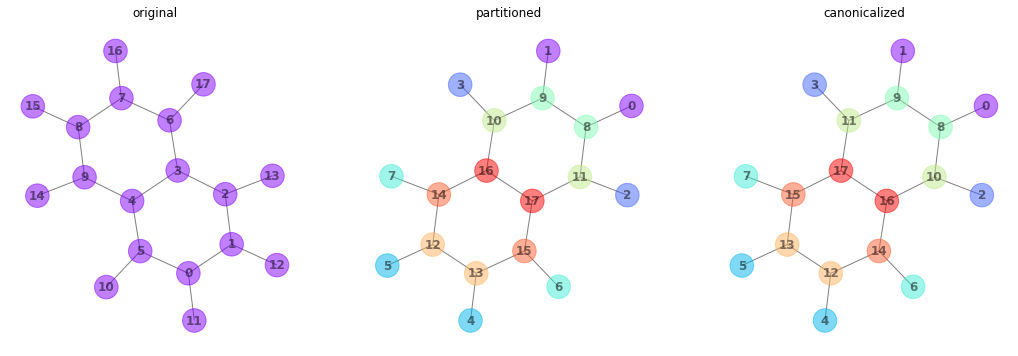

In [6]:
canonical_idcs = assign_canonical_labels(m_partitioned, 0, show_traversal_order=True)
m_canonicalized = nx.relabel_nodes(m_partitioned, canonical_idcs, copy=True)

draw_molecules([m, m_partitioned, m_canonicalized], ["original", "partitioned", "canonicalized"], highlight="partition")

# Serialization
The serialization should result in a string representation of the molecule. The string representation should allow for the automatized reconstruction of the molecule's topology (i.e., the molecular graph), and ideally, the representation should be intuitive enough for a human to be able to reconstruct the molecular graph.

Our string representation consists of the sum formula, followed by a sequence of tuples. Each tuple represents the labels of two connected atoms (i.e., (label atom_A, label atom_B)). For example, the string representation of ethanol is `C2H6O/0-6/1-6/2-6/3-7/4-7/5-8/6-7/7-8`. In order to be able to reconstruct the molecule based on this representation, we organize the tuples such that increasing atom labels pertain to atoms with increasing atomic number. This means that we can infer the atomic number associated with an atom label from the sum formula. For example, the sum formula of ethanol indicates that the molecule consists of six Hs, two Cs and one O. Since increasing labels pertain to atoms with increasing atomic numbers, we can infer that the labels 0 through 6 pertain to Hs, labels 7 and 8 pertain to Cs, and finally, label 8 pertains to an O.

In [7]:
testfiles = list(Path("tests/molfiles").glob("*/*.mol"))
for f in testfiles:
    m = graph_from_file(f)
    print(f"{f.stem}:\n{serialize_molecule(canonicalize_molecule(m, 0))}\n")

10tertButyl10isopropyltridecanoic acid:
C20H40O2/0-40/1-40/2-40/3-41/4-41/5-41/6-42/7-42/8-42/9-43/10-43/11-43/12-44/13-44/14-44/15-45/16-45/17-45/18-46/19-46/20-47/21-47/22-48/23-48/24-49/25-49/26-50/27-50/28-51/29-51/30-52/31-52/32-53/33-53/34-54/35-54/36-55/37-55/38-56/39-61/40-46/41-56/42-56/43-57/44-57/45-57/46-53/47-48/47-49/48-50/49-51/50-52/51-54/52-55/53-58/54-58/55-59/56-58/57-58/59-60/59-61

14Ethyl14methylheptadecanoic acid:
C20H40O2/0-40/1-40/2-40/3-41/4-41/5-41/6-42/7-42/8-42/9-43/10-43/11-44/12-44/13-45/14-45/15-46/16-46/17-47/18-47/19-48/20-48/21-49/22-49/23-50/24-50/25-51/26-51/27-52/28-52/29-53/30-53/31-54/32-54/33-55/34-55/35-56/36-56/37-57/38-57/39-61/40-43/41-54/42-58/43-55/44-45/44-46/45-47/46-48/47-49/48-50/49-51/50-52/51-53/52-56/53-57/54-58/55-58/56-58/57-59/59-60/59-61

18Methylnonadecanoic acid:
C20H40O2/0-40/1-40/2-40/3-41/4-41/5-41/6-42/7-42/8-43/9-43/10-44/11-44/12-45/13-45/14-46/15-46/16-47/17-47/18-48/19-48/20-49/21-49/22-50/23-50/24-51/25-51/26-52/27-52